# Analítica de datos - ejemplo de clase

## Lectura base de datos y partición conjunto de entrenamiento y conjunto de evaluación

Nota: conjunto de evaluación no se utiliza en NINGUNA etapa de entrenamiento 

In [1]:
#Paso 1: Lectura
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from funciones_fifa import dummy_fifa, pre_exploratorio, save_fig, code_euro

from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

%matplotlib inline
csv_path = 'datos/data.csv'

Xdata = pd.read_csv(csv_path)

col_drop = ['Unnamed: 0', 'Name','ID','Photo','Flag',
           'Club Logo','Loaned From']
Xdata.drop(columns = col_drop, inplace = True)


In [2]:
#Paso 2: Particion entrenamiento y validacion
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest = train_test_split(Xdata,test_size=0.8)
col_sal = "Release Clause"
ytrain = Xtrain[col_sal]
ytest = Xtest[col_sal]
Xtrain.drop(columns=col_sal,inplace=True)
Xtest.drop(columns=col_sal,inplace=True)

ytrain = SimpleImputer(strategy="most_frequent").fit_transform(pd.DataFrame(ytrain)).reshape(-1)
ytrain = code_euro(ytrain)

ytest = SimpleImputer(strategy="most_frequent").fit_transform(pd.DataFrame(ytest)).reshape(-1)
ytest = code_euro(ytest)


In [3]:
col_euro = ['Value','Wage'];
col_stats = ['LS','ST','RS','LW','LF','CF','RF','RW','LAM',
             'CAM','RAM','LM','LCM','CM','RCM','RM','LWB',
             'LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB'];

cat = ['Nationality','Club','Body Type','Position','Preferred Foot',
        'Work Rate','Real Face','Contract Valid Until']
items = [] 
for i in cat:
    items += [list(Xdata[i].value_counts().index)]
cat_usr = dict(zip(cat, items))

dummy = dummy_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)
Xtrain_pre = dummy.fit_transform(Xtrain)


In [4]:
Xtrain_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3641 entries, 15821 to 1860
Data columns (total 81 columns):
Age                         3641 non-null int64
Nationality                 3641 non-null float64
Overall                     3641 non-null int64
Potential                   3641 non-null int64
Club                        3641 non-null float64
Value                       3641 non-null float64
Wage                        3641 non-null float64
Special                     3641 non-null int64
Preferred Foot              3641 non-null float64
International Reputation    3641 non-null float64
Weak Foot                   3641 non-null float64
Skill Moves                 3641 non-null float64
Work Rate                   3641 non-null float64
Body Type                   3641 non-null float64
Real Face                   3641 non-null float64
Position                    3641 non-null float64
Jersey Number               3641 non-null float64
Joined                      3641 non-null float

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3641 samples in 0.020s...
[t-SNE] Computed neighbors for 3641 samples in 3.333s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3641
[t-SNE] Computed conditional probabilities for sample 2000 / 3641
[t-SNE] Computed conditional probabilities for sample 3000 / 3641
[t-SNE] Computed conditional probabilities for sample 3641 / 3641
[t-SNE] Mean sigma: 2.319452
[t-SNE] Computed conditional probabilities in 0.248s
[t-SNE] Iteration 50: error = 82.9790649, gradient norm = 0.0471062 (50 iterations in 4.475s)
[t-SNE] Iteration 100: error = 74.9684143, gradient norm = 0.0067414 (50 iterations in 3.077s)
[t-SNE] Iteration 150: error = 74.6460876, gradient norm = 0.0047695 (50 iterations in 3.173s)
[t-SNE] Iteration 200: error = 74.5282822, gradient norm = 0.0028742 (50 iterations in 3.262s)
[t-SNE] Iteration 250: error = 74.4636688, gradient norm = 0.0039554 (50 iterations in 3.268s)
[t-SNE] KL divergence after 250 iterati

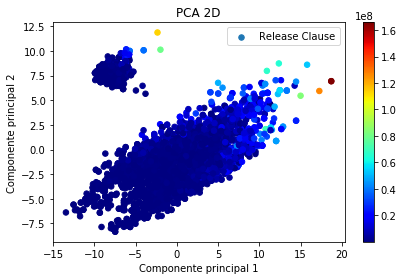

Guardando... relevancia_PCA


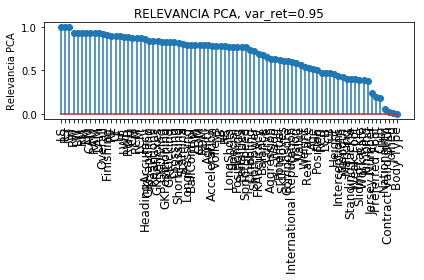

Guardando... tsne_2D


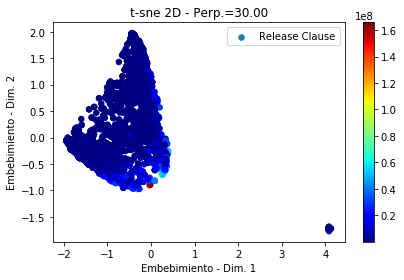

True

In [5]:
#%% Paso 3 : Analisis exploratorio
#preproceso entrada  y salida para analisis exploratorio
img_path = 'im2/'
pre_exploratorio(Xtrain_pre,ytrain,img_path,col_sal)

In [6]:
#%% Paso 4 : Escoger modelo por gridsearchCV utilizando pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA 
from sklearn.linear_model import LinearRegression

steps=[('dummy_pre', dummy_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)),
       ('rep',  PCA()),
            ('reg', RandomForestRegressor())]
parameters = {'rep__n_components' : [0.7,0.8,0.9],              
              'reg__max_depth': [8,10,12],
              'reg__n_estimators' : [10,20,40,100],
              }

pipeline = Pipeline(steps = steps)

grid_search = GridSearchCV(pipeline, parameters, n_jobs=4,cv=3,
                           scoring='neg_mean_absolute_error',verbose=10)

grid_search.fit(Xtrain, ytrain)
#mejor modelo entrenado
best_model = grid_search.best_estimator_

print("\nMejores parámetros:\n")
print(grid_search.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.9min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  6.1min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  8.1min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  9.1min
[Parallel(n_jobs=4)]: Done 108 out of 108 | elapsed: 10.7min finished



Mejores parámetros:

{'reg__max_depth': 8, 'reg__n_estimators': 40, 'rep__n_components': 0.9}


# Calcular rendimiento en cojunto de test

mae(test)=819535.72
Guardando... mae_testing_set


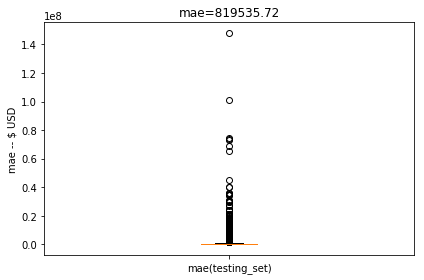

In [7]:
#%% Paso 5: evaluar sobre Xtest
ytest_e = best_model.predict(Xtest)
vmae = mean_absolute_error(np.array(ytest).reshape(1,-1),np.array(ytest_e).reshape(1,-1),multioutput='raw_values')
plt.boxplot(vmae)
print('mae(test)=%.2f' % mean_absolute_error(ytest,ytest_e))
plt.xticks([1],labels=['mae(testing_set)'])
plt.ylabel('mae -- $ USD')
plt.title('mae=%.2f'% mean_absolute_error(ytest,ytest_e))
save_fig(img_path,"mae_testing_set")
plt.show()

In [13]:
ytrain.max()

166100000.0